In [4]:
import numpy as np
import pandas as pd
import time
import timm
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torchvision
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
import copy

os.chdir('/home/xzwzhang/Codes/')

In [5]:
data_transforms = {
    'train_data': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test_data': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'emirhan_human_dataset/datasets/human_data/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train_data', 'test_data']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train_data', 'test_data']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train_data', 'test_data']}
class_names = image_datasets['train_data'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

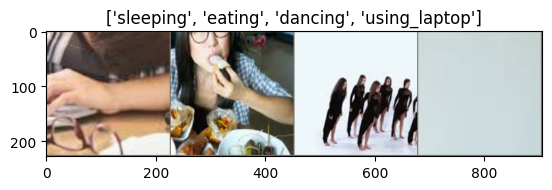

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train_data']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train_data', 'test_data']:
            if phase == 'train_data':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train_data'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train_data':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train_data':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'test_data' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            if phase == 'train_data':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.cpu())
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.cpu())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)

    epochs_range = range(num_epochs)
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    ax[0].plot(epochs_range, train_acc_history, label='Train Accuracy')
    ax[0].plot(epochs_range, val_acc_history, label='Validation Accuracy')
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()

    ax[1].plot(epochs_range, train_loss_history, label='Train Loss')
    ax[1].plot(epochs_range, val_loss_history, label='Validation Loss')
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].legend()

    plt.show()

    return model


In [9]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test_data']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


In [10]:
model = timm.create_model("tf_efficientnetv2_s_in21ft1k", pretrained=True, drop_rate=0.3, num_classes=len(class_names))
model = model.to(device)
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/home/xzwzhang/.local/lib/python3.10/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name tf_efficientnetv2_s_in21ft1k to current tf_efficientnetv2_s.in21k_ft_in1k.
  model = create_fn(


Epoch 0/9
----------
train_data Loss: 1.8573 Acc: 0.4297
test_data Loss: 0.8944 Acc: 0.7300

Epoch 1/9
----------
train_data Loss: 1.3233 Acc: 0.5943
test_data Loss: 0.8408 Acc: 0.7557

Epoch 2/9
----------
train_data Loss: 1.1798 Acc: 0.6311
test_data Loss: 0.7236 Acc: 0.7853

Epoch 3/9
----------
train_data Loss: 1.0813 Acc: 0.6673
test_data Loss: 0.6943 Acc: 0.7897

Epoch 4/9
----------
train_data Loss: 0.9954 Acc: 0.6923
test_data Loss: 0.6753 Acc: 0.7997

Epoch 5/9
----------
train_data Loss: 0.9403 Acc: 0.7047
test_data Loss: 0.6475 Acc: 0.8053

Epoch 6/9
----------
train_data Loss: 0.8904 Acc: 0.7182
test_data Loss: 0.6658 Acc: 0.7927

Epoch 7/9
----------
train_data Loss: 0.8133 Acc: 0.7423
test_data Loss: 0.6254 Acc: 0.8150

Epoch 8/9
----------
train_data Loss: 0.7685 Acc: 0.7569
test_data Loss: 0.6188 Acc: 0.8173

Epoch 9/9
----------
train_data Loss: 0.7586 Acc: 0.7609
test_data Loss: 0.6202 Acc: 0.8180

Training complete in 27m 51s
Best val Acc: 0.8180


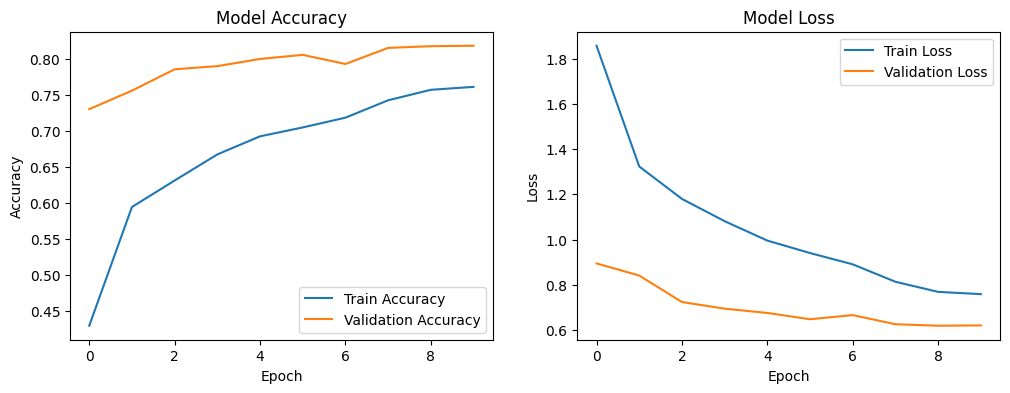

In [11]:
model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

In [12]:
def get_predictions(model, dataloaders, device):
    model.eval()
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for inputs, labels in dataloaders['test_data']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())
    
    return true_labels, pred_labels

In [13]:
from sklearn.metrics import classification_report
import pandas as pd

true_labels, pred_labels = get_predictions(model, dataloaders, device)

true_labels = [class_names[label] for label in true_labels]
pred_labels = [class_names[label] for label in pred_labels]

report = classification_report(true_labels, pred_labels, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()

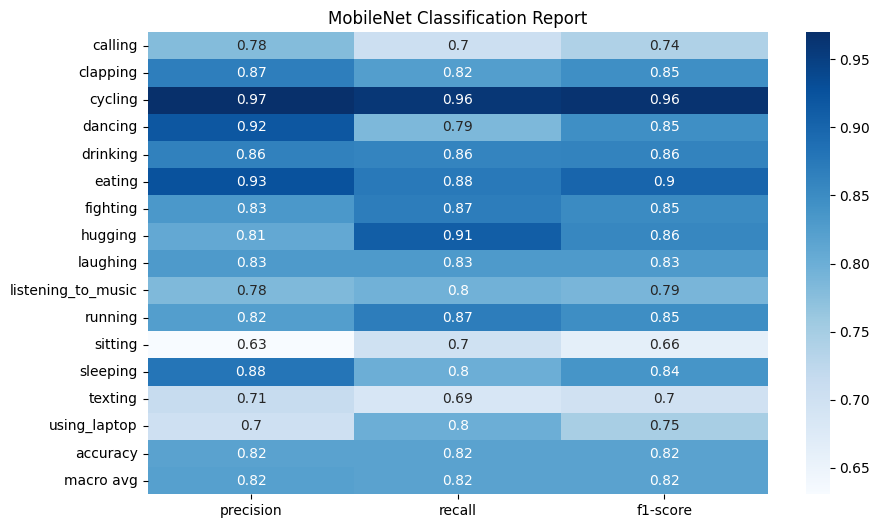

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='Blues')
plt.title('MobileNet Classification Report')
plt.show()

In [17]:
torch.save(model, 'model_complete.pth')